In [1]:
!pip install torchvision numpy matplotlib torch

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install pytorch

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for pytorch (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [19 lines of output]
      Traceback (most recent call last):
        File "/home/dananjay/MachineVision/.venv/lib/python3.10/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 353, in <module>
          main()
        File "/home/dananjay/MachineVision/.venv/lib/python3.10/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 335, in main
          json_out['return_val'] = hook(**hook_input['kwargs'])
        File "/home/dananjay/MachineVision/.venv/lib/python3.10/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 251, in build_wheel
          return _build_backend().build_wheel(wheel_directory, config_settings,
        File "/tmp/pip-build-env-8

In [1]:
import torch
import torch.nn as nn
from PIL import Image

In [2]:
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256 resolution
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize images between -1 and 1
])

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(channels)
        )

    def forward(self, x):
        return x + self.block(x)

In [4]:
class Generator(nn.Module):
    def __init__(self, input_channels=3, output_channels=3, num_residual_blocks=9):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=7, stride=1, padding=3),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )

        in_channels = 64
        out_channels = in_channels * 2
        for _ in range(2):
            self.model.add_module(
                f"downsampling_{_}",
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
                    nn.InstanceNorm2d(out_channels),
                    nn.ReLU(inplace=True)
                )
            )
            in_channels = out_channels
            out_channels = in_channels * 2

        # Residual Blocks
        for _ in range(num_residual_blocks):
            self.model.add_module(f"residual_block_{_}", ResidualBlock(in_channels))

        # Upsampling
        out_channels = in_channels // 2
        for _ in range(2):
            self.model.add_module(
                f"upsampling_{_}",
                nn.Sequential(
                    nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
                    nn.InstanceNorm2d(out_channels),
                    nn.ReLU(inplace=True)
                )
            )
            in_channels = out_channels
            out_channels = in_channels // 2

        # Output Layer
        self.model.add_module(
            "output_layer",
            nn.Sequential(
                nn.Conv2d(in_channels, output_channels, kernel_size=7, stride=1, padding=3),
                nn.Tanh()
            )
        )

    def forward(self, x):
        return self.model(x)

In [5]:
class Discriminator(nn.Module):
    def __init__(self, input_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, stride=2):
            block = [
                nn.Conv2d(in_filters, out_filters, kernel_size=4, stride=stride, padding=1),
                nn.InstanceNorm2d(out_filters),
                nn.LeakyReLU(0.2, inplace=True)
            ]
            return block

        self.model = nn.Sequential(
            *discriminator_block(input_channels, 64, stride=2),
            *discriminator_block(64, 128, stride=2),
            *discriminator_block(128, 256, stride=2),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=1)  # PatchGAN output
        )

    def forward(self, img):
        return self.model(img)

In [6]:
G = Generator()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G.to(device)

Generator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
    (downsampling_0): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
    )
    (downsampling_1): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
    )
    (residual_block_0): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU(inplace=True)
 

In [7]:
G.load_state_dict(torch.load('./generator_G.pth', map_location=torch.device('cuda')))
G.eval()

/tmp/ipykernel_385490/2831510481.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load('./generator_G.pth', map_location=torch.device('cuda')))


Generator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
    (downsampling_0): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
    )
    (downsampling_1): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
    )
    (residual_block_0): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU(inplace=True)
 

In [13]:
!pip uninstall numpy

Found existing installation: numpy 2.1.3
Uninstalling numpy-2.1.3:
  Would remove:
    /home/dananjay/.local/bin/f2py
    /home/dananjay/.local/bin/numpy-config
    /home/dananjay/.local/lib/python3.10/site-packages/numpy-2.1.3.dist-info/*
    /home/dananjay/.local/lib/python3.10/site-packages/numpy.libs/libgfortran-040039e1-0352e75f.so.5.0.0
    /home/dananjay/.local/lib/python3.10/site-packages/numpy.libs/libquadmath-96973f99-934c22de.so.0.0.0
    /home/dananjay/.local/lib/python3.10/site-packages/numpy.libs/libscipy_openblas64_-ff651d7f.so
    /home/dananjay/.local/lib/python3.10/site-packages/numpy/*
Proceed (Y/n)? ^C
ERROR: Operation cancelled by user


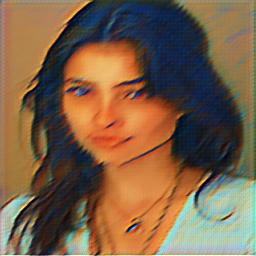

In [14]:
from PIL import Image
import torch
from torchvision import transforms

# Preprocess input image
img = Image.open("./Dataset/content_images/content1.jpeg")
input_image = transform(img).unsqueeze(0)

# Move the input image to the same device as the generator
input_image = input_image.to(device)

# Generate styled image
with torch.no_grad():
    generated_image = G(input_image)

# Post-process the generated image for visualization
generated_image = generated_image.squeeze(0).cpu()  # Move back to CPU for visualization
generated_image = generated_image * 0.5 + 0.5  # Denormalize
generated_image = transforms.ToPILImage()(generated_image)

from IPython.display import display

display(generated_image)

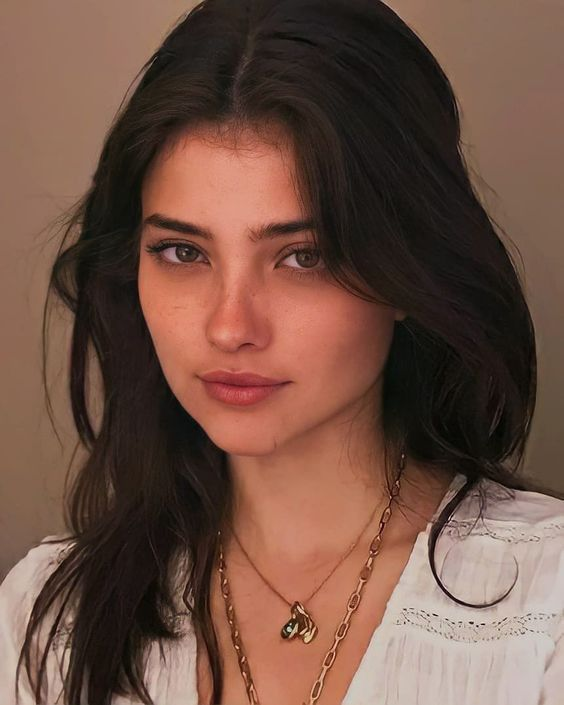

In [15]:
display(img)

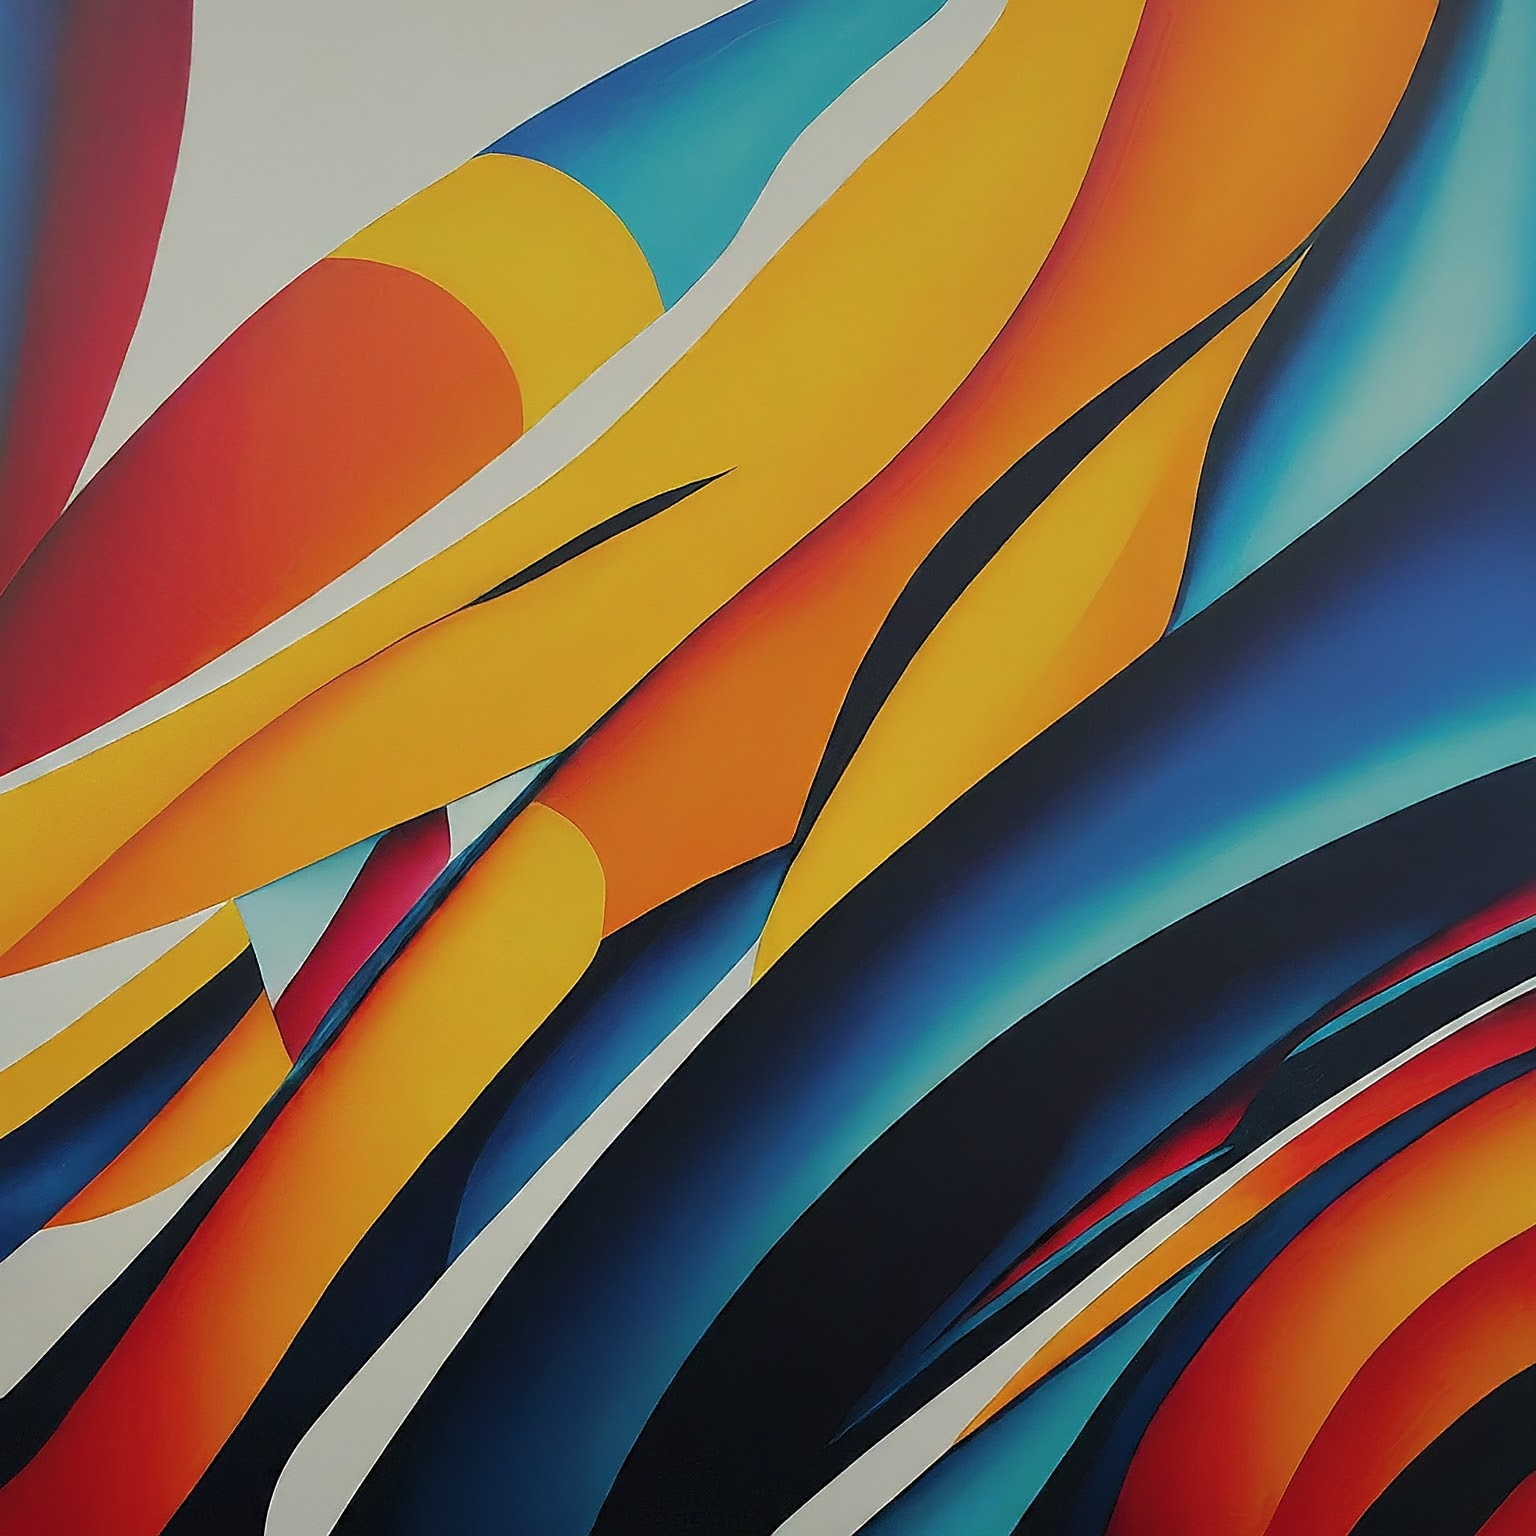

In [13]:
base_image = Image.open("./Dataset/base_style_image/style1.jpeg")
display(base_image)